## A "Quick, draw!" implementation using CNN 
This jupyter notbook contains the complete implementation of a 9-layered CNN model, through which we are going to be training a collection of hand-drawn dataset compilation and save the trained model. From this saved model we are going to classify our new hand drawn image into one of those categories.

In [2]:
# Imports
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

### Load the data from the folder of .npy files
Load the numpy array images onto the memory

In [3]:
# load the data
arm = np.load('data/arm.npy')
bicycle = np.load('data/bicycle.npy')
book = np.load('data/book.npy')
paperClip = np.load('data/paperclip.npy')

# print number of images in dataset and numpy array size of each image
print "no_of_pics, pixels_size"
print(arm.shape)
print(bicycle.shape)
print(book.shape)
print(paperClip.shape)

no_of_pics, pixels_size
(120951, 784)
(126527, 784)
(119364, 784)
(127129, 784)


In [4]:
# add a column with labels, 0=book, 1=bicycle, 2=book, 3=paperclip 
arm = np.c_[arm, np.zeros(len(arm))]
bicycle = np.c_[bicycle, np.ones(len(bicycle))]
book = np.c_[book, 2*np.ones(len(book))]
paperClip = np.c_[paperClip, 3*np.ones(len(paperClip))]

In [5]:
# Function to plot 28x28 pixel drawings that are stored in a numpy array.
# Specify how many rows and cols of pictures to display (default 4x5).  
# If the array contains less images than subplots selected, surplus subplots remain empty.
def plot_samples(input_array, rows=1, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

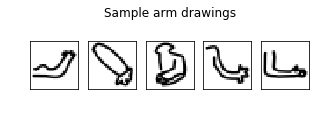

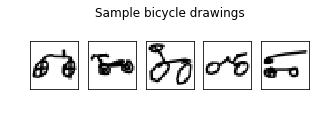

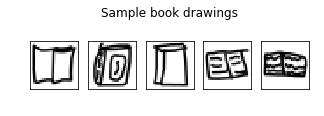

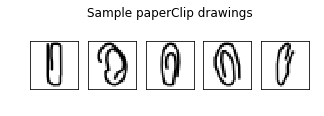

In [6]:
# Plot arm samples
plot_samples(arm, title='Sample arm drawings\n')
plot_samples(bicycle, title = 'Sample bicycle drawings\n')
plot_samples(book, title = 'Sample book drawings\n')
plot_samples(paperClip, title = 'Sample paperClip drawings\n')

In [7]:
# merge the arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = np.concatenate((arm[:10000,:-1], bicycle[:10000,:-1], book[:10000,:-1], paperClip[:10000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((arm[:10000,-1], bicycle[:10000,-1], book[:10000,-1], paperClip[:10000,-1]), axis=0).astype('float32') # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# Use a 50:50 split, training the models on 10'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

# CNN part


### A 9layer CNN
Let's try out a Convolutional Neural Network (CNN) with Keras. I will use a model from this tutorial by Jason Brownlee. It has the following 9 layers:

1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
8. Fully connected layer with 128 neurons and rectifier activation.
9. Fully connected layer with 50 neurons and rectifier activation.
10. Output layer.
Keras requires one hot encoding of the y labels:

In [8]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
s = X_train_cnn.shape
print s, num_classes

(20000, 1, 28, 28) 4


In [9]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
%%time

# build the model
model = cnn_model()
# Fit the model
history = model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=30, batch_size=50)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1]*100, "%")

# Save weights
model.save_weights('quickdraw_neuralnet.h5')
model.save('quickdraw.model')
print "Model is saved"

Train on 20000 samples, validate on 20000 samples
Epoch 1/30
20000/20000 [==============================] - 39s 2ms/step - loss: 0.3868 - acc: 0.8685 - val_loss: 0.1836 - val_acc: 0.9444
Epoch 2/30
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1990 - acc: 0.9379 - val_loss: 0.1596 - val_acc: 0.9515
Epoch 3/30
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1598 - acc: 0.9492 - val_loss: 0.1481 - val_acc: 0.9548
Epoch 4/30
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1363 - acc: 0.9568 - val_loss: 0.1236 - val_acc: 0.9626
Epoch 5/30
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1169 - acc: 0.9631 - val_loss: 0.1107 - val_acc: 0.9670
Epoch 6/30
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1082 - acc: 0.9641 - val_loss: 0.1143 - val_acc: 0.9645
Epoch 7/30
20000/20000 [==============================] - 38s 2ms/step - loss: 0.0973 - acc: 0.9690 - val_loss: 0.1058 - val_acc

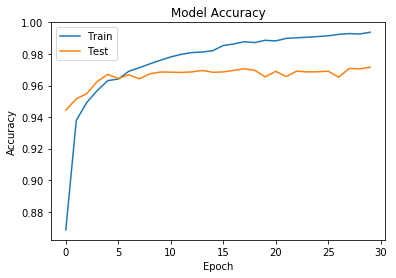

In [11]:
# Plotting the history of accuracy 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

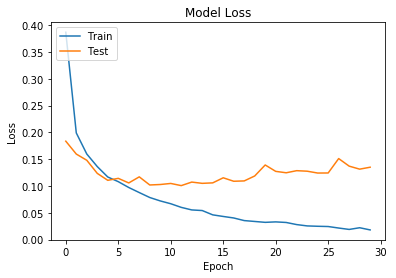

In [12]:
# Summarizing the history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Now, prediction with the saved model

Running the prediction on the saved Testing data set

In [13]:
model = load_model('quickdraw.model')
model.summary()

img_width = 28
img_height = 28

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 24, 24)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 12, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 10, 10)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 5, 5)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 5, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               48128     
__________

The drawing is identified as -->  bicycle  <-- with a probability of  100.0
The drawing is identified as -->  bicycle  <-- with a probability of  100.0
The drawing is identified as -->  arm  <-- with a probability of  99.99927282333374
The drawing is identified as -->  arm  <-- with a probability of  99.97759461402893
The drawing is identified as -->  paper_clip  <-- with a probability of  100.0
The drawing is identified as -->  bicycle  <-- with a probability of  100.0


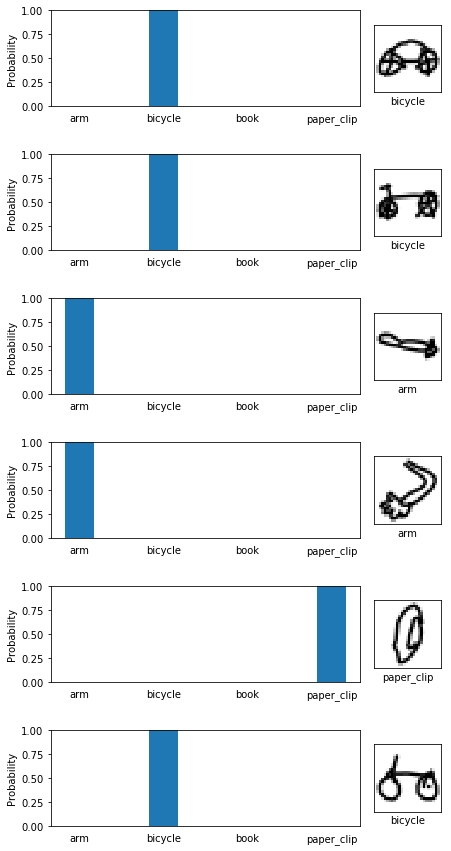

In [14]:
# store the label codes in a dictionary
label_dict = {0:'arm', 1:'bicycle', 2:'book', 3:'paper_clip'}

#print X_test_cnn[0]
# CNN predictions
cnn_probab = model.predict(X_test_cnn, batch_size=32, verbose=0)
#print cnn_probab[4]

# Plotting the X_test data and finding out the probabilites of prediction
fig, ax = plt.subplots(figsize=(7,15))
    
for i in list(range(6)):
    
    print "The drawing is identified as --> ", label_dict[y_test[i]], " <-- with a probability of ", max(cnn_probab[i])*100
    
    # plot probabilities:
    ax = plt.subplot2grid((6, 5), (i, 0), colspan=4);
    plt.bar(np.arange(4), cnn_probab[i], 0.35, align='center');
    plt.xticks(np.arange(4), ['arm','bicycle','book','paper_clip'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # plot picture:
    ax = plt.subplot2grid((6, 5), (i, 4), colspan=1);
    plt.imshow(X_test[i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[i]]); # get the label from the dict
    plt.xticks([])
    plt.yticks([])

(1, 1, 28, 28)


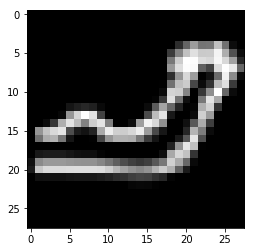

In [15]:
img = cv2.imread('arm.png', 0)
#ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
img = cv2.resize(img, (img_width, img_height))
plt.imshow((img.reshape((28,28))), cmap='gray_r')

#print img, "\n"
arr = np.array(img-255)
#print arr
arr = np.array(arr/255.)
#print arr

new_test_cnn = arr.reshape(1, 1, 28, 28).astype('float32')
print new_test_cnn.shape

The drawing is identified as -->  arm  <-- with a probability of  100.0


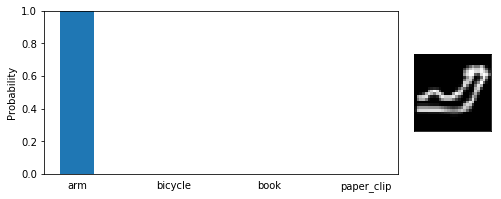

In [16]:
import operator
# CNN predictions
new_cnn_predict = model.predict(new_test_cnn, batch_size=32, verbose=0)

pr = model.predict_classes(arr.reshape((1, 1, 28, 28)))
#print pr
# Plotting the X_test data and finding out the probabilites of prediction
fig, ax = plt.subplots(figsize=(8,3))

# Finding the max probability
max_index, max_value = max(enumerate(new_cnn_predict[0]), key=operator.itemgetter(1))

print "The drawing is identified as --> ", label_dict[max_index], " <-- with a probability of ", max_value*100

for i in list(range(1)):
    # plot probabilities:
    ax = plt.subplot2grid((1, 5), (i, 0), colspan=4);
    plt.bar(np.arange(4), new_cnn_predict[i], 0.35, align='center');
    plt.xticks(np.arange(4), ['arm','bicycle','book','paper_clip'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)
    
     # plot picture:
    ax = plt.subplot2grid((1, 5), (i, 4), colspan=1);
    plt.imshow((img.reshape(28,28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])